In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]



In [2]:
# preparing data
# generate CSV metadata file to read img paths and labels from it
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train\nevus\*
Reading data/train\seborrheic_keratosis\*
Reading data/train\melanoma\*
Saving train.csv
Reading data/valid\nevus\*
Reading data/valid\seborrheic_keratosis\*
Reading data/valid\melanoma\*
Saving valid.csv
Reading data/test\nevus\*
Reading data/test\seborrheic_keratosis\*
Reading data/test\melanoma\*
Saving test.csv


In [3]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [4]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [5]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

In [6]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds


valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

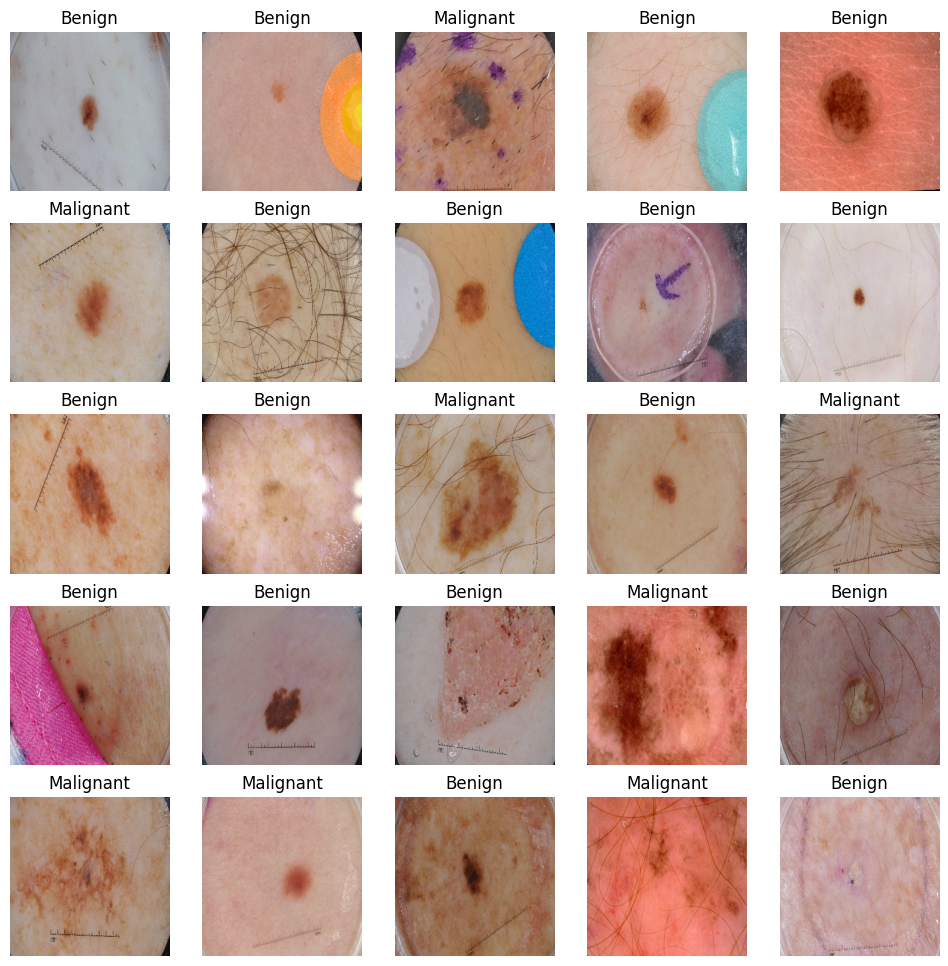

In [7]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [8]:
# building the model
# InceptionV3 model & pre-trained weights
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [9]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=100,
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8034
Epoch 1: val_loss improved from inf to 0.50471, saving model to benign-vs-malignant_64_rmsprop_0.505.h5


C:\Users\ayush\.colab\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 156s 5s/step - loss: 0.4120 - accuracy: 0.8034 - val_loss: 0.5047 - val_accuracy: 0.7969
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8095
Epoch 2: val_loss improved from 0.50471 to 0.46281, saving model to benign-vs-malignant_64_rmsprop_0.463.h5
31/31 [==============================] - 105s 3s/step - loss: 0.3927 - accuracy: 0.8095 - val_loss: 0.4628 - val_accuracy: 0.8125
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8175
Epoch 3: val_loss did not improve from 0.46281
31/31 [==============================] - 98s 3s/step - loss: 0.3768 - accuracy: 0.8175 - val_loss: 0.4653 - val_accuracy: 0.7969
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8251
Epoch 4: val_loss did not improve from 0.46281
31/31 [==============================] - 96s 3s/step - loss: 0.3670 - accuracy: 0.8251 - val_loss: 0.4820 - val_accuracy: 0.

In [10]:
# evaluation

# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  return ds


test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [17]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [18]:

# get the current working directory
cwd = os.getcwd()

# join the directory path with the file name
weights_path = os.path.join(cwd, "benign-vs-malignant_64_rmsprop_0.399.h5")

# load the weights with the least loss
m.load_weights(weights_path)
m.load_weights("benign-vs-malignant_64_rmsprop_0.399.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'c:\Users\ayush\Downloads\AI ML\benign-vs-malignant_64_rmsprop_0.399.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.7710431814193726   Accuracy: 0.8050000071525574


In [20]:
from sklearn.metrics import accuracy_score

def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23
# get predictions with 23% threshold
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)
accuracy_after = accuracy_score(y_test, y_pred)
print("Accuracy after setting the threshold:", accuracy_after)

19/19 [==============================] - 26s 1s/step
Accuracy after setting the threshold: 0.8016666666666666


In [1]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()


def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_roc_auc(y_test, y_pred)
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

NameError: name 'y_test' is not defined

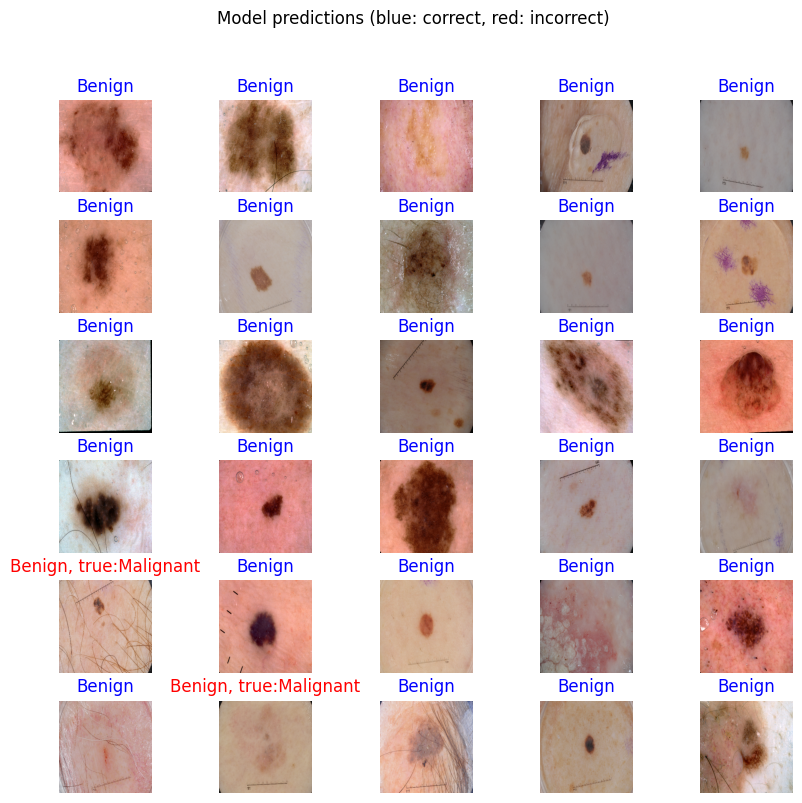

In [22]:
def plot_images(X_test, y_pred, y_test):
  predicted_class_names = np.array([class_names[int(round(id))] for id in y_pred])
  # some nice plotting
  plt.figure(figsize=(10,9))
  for n in range(30, 60):
      plt.subplot(6,5,n-30+1)
      plt.subplots_adjust(hspace = 0.3)
      plt.imshow(X_test[n])
      # get the predicted label
      predicted_label = predicted_class_names[n]
      # get the actual true label
      true_label = class_names[int(round(y_test[n]))]
      if predicted_label == true_label:
          color = "blue"
          title = predicted_label.title()
      else:
          color = "red"
          title = f"{predicted_label.title()}, true:{true_label.title()}"
      plt.title(title, color=color)
      plt.axis('off')
  _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
  plt.show()

plot_images(X_test, y_pred, y_test)

In [23]:
# a function given a function, it predicts the class of the image
def predict_image_class(img_path, model, threshold=0.5):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.expand_dims(img, 0) # Create a batch
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  predictions = model.predict(img)
  score = predictions.squeeze()
  if score >= threshold:
    print(f"This image is {100 * score:.2f}% malignant.")
  else:
    print(f"This image is {100 * (1 - score):.2f}% benign.")
    
  plt.imshow(img[0])
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 75ms/step


This image is 92.24% benign.


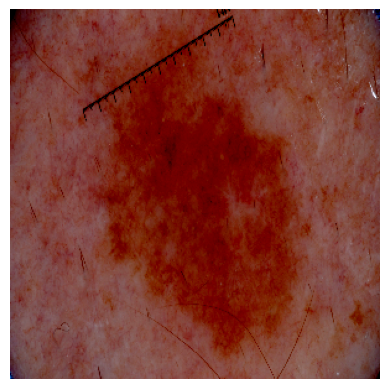

In [24]:
predict_image_class("data/test/melanoma/ISIC_0013767.jpg", m)

1/1 [==============================] - 0s 78ms/step


This image is 99.61% benign.


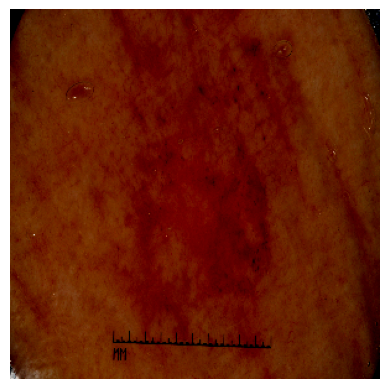

In [25]:
predict_image_class("data/test/melanoma/ISIC_0014506.jpg", m)

1/1 [==============================] - 0s 70ms/step


This image is 96.33% benign.


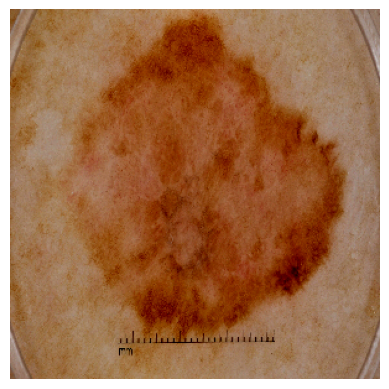

In [26]:
predict_image_class("data/test/melanoma/ISIC_0013374.jpg", m)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#CNN
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load your data
# X_train, y_train = load_your_data()

# Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to [0,1]
    rotation_range=20,     # Randomly rotate the images in the range (degrees, 0 to 180)
    width_shift_range=0.2, # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,# Randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # Randomly flip images
    validation_split=0.2   # Fraction of images reserved for validation
)

# Assuming your data is stored in a directory, with one subdirectory per class
train_data = datagen.flow_from_directory(
    'F:\\AI ML\\data\\train',
    target_size=(64, 64),  # The dimensions to which all images found will be resized
    batch_size=32,
    class_mode='binary',   # 'binary' if you have two classes, otherwise 'categorical'
    subset='training'      # Specify this is training data
)

validation_data = datagen.flow_from_directory(
    'F:\\AI ML\\data\\valid',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'    # Specify this is validation data
)

# Now you can use these generators to train your model
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)

Found 1602 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Epoch 1/10
51/51 [==============================] - 244s 5s/step - loss: 0.3203 - accuracy: 0.6854 - val_loss: 0.2821 - val_accuracy: 0.5172
Epoch 2/10
51/51 [==============================] - 203s 4s/step - loss: 0.2713 - accuracy: 0.6854 - val_loss: -0.0175 - val_accuracy: 0.5172
Epoch 3/10
51/51 [==============================] - 188s 4s/step - loss: 0.2499 - accuracy: 0.6854 - val_loss: -0.0908 - val_accuracy: 0.5172
Epoch 4/10
51/51 [==============================] - 189s 4s/step - loss: 0.2223 - accuracy: 0.6854 - val_loss: -0.1541 - val_accuracy: 0.5172
Epoch 5/10
51/51 [==============================] - 204s 4s/step - loss: 0.2082 - accuracy: 0.6854 - val_loss: -0.3037 - val_accuracy: 0.5172
Epoch 6/10
51/51 [==============================] - 210s 4s/step - loss: 0.2921 - accuracy: 0.6854 - val_loss: -0.1853 - val_accuracy: 0.5172
Epoch 7/10
51/51 [==============================] - 203s 4s/step - 

In [5]:
model.save('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')
from tensorflow.keras.models import load_model

loaded_model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

C:\Users\ayush\.colab\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Ask the user for the image path
img_path = input("Please enter the path to your image: ")

# Now you can load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Resize the image to (64, 64)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Load your trained model
model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

# Use the model to make a prediction
preds = model.predict(x)

# Decode the prediction
# Note: You might need to replace `decode_predictions` with your own function
# if your model was not trained on ImageNet
print('Predicted:', preds[0][0])
#The output of the model is a number between 0 and 1, which represents the probability that the image belongs to class 1.
#If the output is greater than 0.5, the model predicts that the image belongs to class 1, otherwise it predicts that the image belongs to class 0.
#if preds[0][0] > 0.5:
    #print("This image is malignant.")

1/1 [==============================] - 0s 64ms/step
Predicted: 1.0


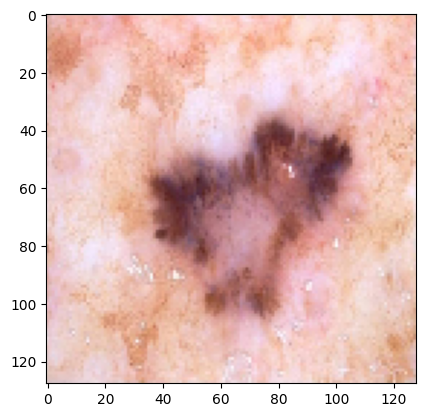

1/1 [==============================] - 0s 24ms/step


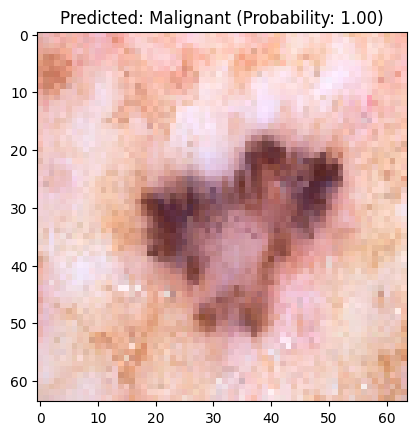

In [4]:
import matplotlib.pyplot as plt

# Load and preprocess the image
img_display = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img_display)
plt.show()
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the model to make a prediction
preds = model.predict(x)

# Display the image and prediction
plt.imshow(img)
if preds[0][0] > 0.5:
    plt.title('Predicted: Malignant (Probability: {:.2f})'.format(preds[0][0]))
else:
    plt.title('Predicted: Benign (Probability: {:.2f})'.format(1 - preds[0][0]))
plt.show()

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 17s 0us/step


In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Now you can use these generators to train your model
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)

Epoch 1/10
51/51 [==============================] - 243s 5s/step - loss: 0.3739 - accuracy: 0.6635 - val_loss: -0.2684 - val_accuracy: 0.5172
Epoch 2/10
51/51 [==============================] - 220s 4s/step - loss: -0.0027 - accuracy: 0.6692 - val_loss: 0.1061 - val_accuracy: 0.5172
Epoch 3/10
51/51 [==============================] - 217s 4s/step - loss: -0.2422 - accuracy: 0.6723 - val_loss: -0.9102 - val_accuracy: 0.5172
Epoch 4/10
51/51 [==============================] - 224s 4s/step - loss: -0.4009 - accuracy: 0.6573 - val_loss: -1.9512 - val_accuracy: 0.5172
Epoch 5/10
51/51 [==============================] - 215s 4s/step - loss: -1.0072 - accuracy: 0.6642 - val_loss: -6.3418 - val_accuracy: 0.5172
Epoch 6/10
51/51 [==============================] - 214s 4s/step - loss: -1.7813 - accuracy: 0.6567 - val_loss: -2.7334 - val_accuracy: 0.5172
Epoch 7/10
51/51 [==============================] - 674s 13s/step - loss: -2.6810 - accuracy: 0.6617 - val_loss: -7.3601 - val_accuracy: 0.5172


In [25]:
model.save('F://AI ML//Vgn_Weight_tf//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
from tensorflow.keras.models import load_model

loaded_model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

C:\Users\ayush\.colab\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Ask the user for the image path
img_path = input("Please enter the path to your image: ")

# Now you can load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to (224, 224)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the model to make a prediction
preds = model.predict(x)

# Print the prediction
print('Predicted:', preds[0][0])

1/1 [==============================] - 0s 409ms/step
Predicted: 0.9999753


1/1 [==============================] - 0s 449ms/step


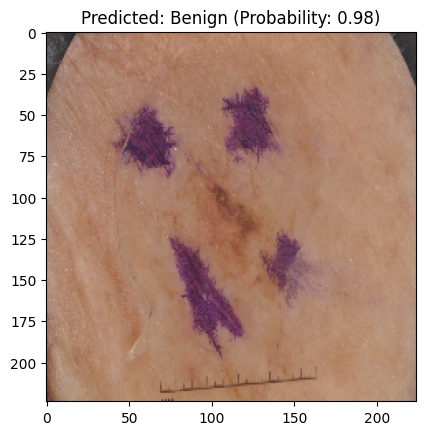

In [29]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess the image
img_display = image.load_img(img_path, target_size=(224, 224))
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the model to make a prediction
preds = model.predict(x)

# Display the image and prediction
plt.imshow(img_display)
if preds[0][0] > 0.5:
    plt.title('Predicted: Malignant (Probability: {:.2f})'.format(preds[0][0]))
else:
    plt.title('Predicted: Benign (Probability: {:.2f})'.format(1 - preds[0][0]))
plt.show()

In [23]:
#Train labels using the image and stores them in .csv file 
import os
import pandas as pd

# Define the directory where your images are stored
image_dir = 'F://AI ML//data//train'

# Get a list of all images
all_images = os.listdir(image_dir)

# Create a list to store the labels
labels = []

# Loop through all images
for image in all_images:
    # The label is the part of the filename before the first underscore
    label = image.split('_')[0]
    if label == 'class0':
        labels.append(0)
    elif label == 'class1':
        labels.append(1)
    labels.append(label)
    

# Create a DataFrame with the filenames and labels
df = pd.DataFrame({
    'filename': all_images,
    'label': labels
})

# Save the DataFrame as a CSV file
df.to_csv('labels.csv', index=False)



In [24]:
import os
import pandas as pd

# Define the directory where your images are stored
image_dir = 'F://AI ML//data//train'

# Get a list of all subdirectories (classes) in the image directory
classes = os.listdir(image_dir)

# Create a list to store the labels
labels = []

# Loop through all classes
for class_label in classes:
    # Get a list of all images in the current class
    class_images = os.listdir(os.path.join(image_dir, class_label))

    # Assign labels based on class name
    if class_label == 'class0':
        class_label_value = 0
    elif class_label == 'class1':
        class_label_value = 1
    else:
        class_label_value = -1  # or handle other classes as needed

    # Loop through all images in the current class
    for image in class_images:
        labels.append({
            'filename': os.path.join(class_label, image),  # Assuming you want the subdirectory in the filename
            'label': class_label_value
        })

# Create a DataFrame with the filenames and labels
df = pd.DataFrame(labels)

# Save the DataFrame as a CSV file
df.to_csv('labels.csv', index=False)


In [32]:
import os
import pandas as pd

# Define the directory where your images are stored
image_dir = 'F://AI ML//data'

# Get a list of all subdirectories (classes) in the image directory
classes = os.listdir(image_dir)

# Create a list to store the labels
labels = []

# Loop through all classes
for class_label in classes:
    # Get a list of all images in the current class
    class_images = os.listdir(os.path.join(image_dir, class_label))

    # Assign labels based on class name
    if class_label == 'class0':
        class_label_value = 0
    elif class_label == 'class1':
        class_label_value = 1
    else:
        class_label_value = -1  # or handle other classes as needed

    # Loop through all images in the current class
    for image in class_images:
        labels.append({
            'filename': os.path.join(class_label, image),  # Assuming you want the subdirectory in the filename
            'label': class_label_value
        })

# Create a DataFrame with the filenames and labels
df = pd.DataFrame(labels)

# Save the DataFrame as a CSV file without including the index
df.to_csv('labels.csv', index=False)


In [33]:
import os
import pandas as pd

# Define the directory where your images are stored
image_dir = 'F://AI ML//data//train'

# Get a list of all subdirectories (each representing a class)
classes = os.listdir(image_dir)

# Create a list to store the labels
labels = []

# Create a list to store the filenames
all_images = []

# Loop through all classes
for class_label in classes:
    class_path = os.path.join(image_dir, class_label)
    
    # Check if it's a directory
    if os.path.isdir(class_path):
        # Loop through all images in the class
        for image in os.listdir(class_path):
            # Append the filename to the list
            all_images.append(image)
            
            # Append the class label to the list
            labels.append(class_label)

# Create a DataFrame with the filenames and labels
df = pd.DataFrame({
    'filename': all_images,
    'label': labels
})

# Save the DataFrame as a CSV file
df.to_csv('labels.csv', index=False)


In [26]:
# Load your labels from the CSV file
labels_df = pd.read_csv('F://AI ML//labels.csv')
#labels = labels_df['lables'].tolist()  # replace 'actual_column_name' with your actual column name
print(labels_df.columns)

Index(['filename', 'labels'], dtype='object')


In [35]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)

# This is the model we will use for feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Load and preprocess your images
image_dir = 'F://AI ML//data//train'
images = []
image_names = []
for class_label in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_label)
    for img_path in os.listdir(class_path):
        img = image.load_img(os.path.join(class_path, img_path), target_size=(64, 64))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        images.append(x)
        image_names.append(os.path.join(class_label, img_path))
images = np.vstack(images)

# Extract features from your images
features = feature_extractor.predict(images)

# Check if features is a 1D array
if features.ndim == 1:
    # Reshape to a 2D array with one row
    features = features.reshape((1, -1))
else:
    # Reshape as before
    features = features.reshape((features.shape[0], -1))

# Load your labels from the CSV file
labels_df = pd.read_csv('labels.csv')

# Load your labels from the CSV file
labels_df = pd.read_csv('labels.csv')

# Remove the class label from the filenames
image_names = [name.split('\\')[1] for name in image_names]

# Ensure the labels are in the same order as the images
labels_df = labels_df.set_index('filename').loc[image_names].reset_index()

labels = labels_df['label'].tolist()  # replace 'label' with your actual column name

# Ensure the labels are in the same order as the images
labels_df = labels_df.set_index('filename').loc[image_names].reset_index()

labels = labels_df['label'].tolist()  # replace 'label' with your actual column name

# Encode your labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create and train the SVM
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)


63/63 [==============================] - 41s 643ms/step


SVC()

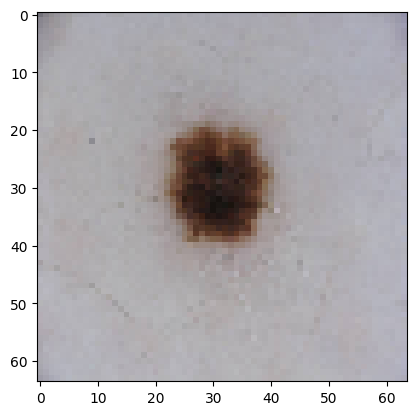

1/1 [==============================] - 0s 53ms/step
The predicted label is: nevus


In [42]:
import matplotlib.pyplot as plt

# Prompt the user for the image path
new_image_path = input("Please enter the image path: ")

# Load and preprocess the new image
img = image.load_img(new_image_path, target_size=(64, 64))

# Display the image
plt.imshow(img)
plt.show()

# Continue with preprocessing
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract features from the new image
new_features = feature_extractor.predict(x)

# Check if new_features is a 1D array
if new_features.ndim == 1:
    # Reshape to a 2D array with one row
    new_features = new_features.reshape((1, -1))
else:
    # Reshape as before
    new_features = new_features.reshape((new_features.shape[0], -1))

# Use the SVM model to make a prediction
prediction = svm_model.predict(new_features)

# Decode the prediction
predicted_label = le.inverse_transform(prediction)

print('The predicted label is:', predicted_label[0])

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the test set
logreg_predictions = logreg.predict(X_test)

# Calculate the accuracy of the Logistic Regression model
logreg_accuracy = accuracy_score(y_test, logreg_predictions)

# Calculate the accuracy of the SVM model
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# Print the accuracies
print('Logistic Regression accuracy:', logreg_accuracy)
print('SVM accuracy:', svm_accuracy)

C:\Users\ayush\.colab\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.6925
SVM accuracy: 0.715


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained models
vgg16_model = load_model('F://AI ML//Vgn_Weight_tf//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
cnn_model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

# Save the models in TensorFlow SavedModel format
vgg16_model.save('vgg16_saved_model')
cnn_model.save('cnn_saved_model')

INFO:tensorflow:Assets written to: vgg16_saved_model\assets


INFO:tensorflow:Assets written to: vgg16_saved_model\assets


INFO:tensorflow:Assets written to: cnn_saved_model\assets


INFO:tensorflow:Assets written to: cnn_saved_model\assets


Found 600 images belonging to 3 classes.
19/19 [==============================] - 163s 9s/step


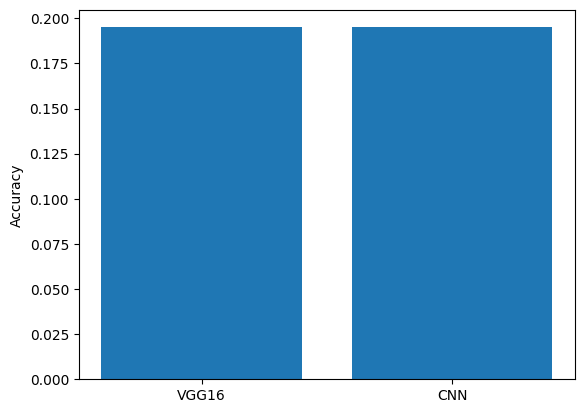

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

# Load your test data
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    'F://AI ML//data//test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Make predictions with both models
vgg16_preds = vgg16_model.predict(test_generator)
cnn_preds = cnn_model.predict(test_generator)

# Convert predictions to class labels
vgg16_preds = np.argmax(vgg16_preds, axis=1)
cnn_preds = np.argmax(cnn_preds, axis=1)

# Calculate the accuracy of the models
vgg16_accuracy = accuracy_score(test_generator.classes, vgg16_preds)
cnn_accuracy = accuracy_score(test_generator.classes, cnn_preds)

# Plot the accuracy
plt.bar(['VGG16', 'CNN'], [vgg16_accuracy, cnn_accuracy])
plt.ylabel('Accuracy')
plt.show()

In [5]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# Load and preprocess the image
img_path = input("Enter the path of the image: ")
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions with both models
vgg16_preds = vgg16_model.predict(x)
cnn_preds = cnn_model.predict(x)

# Convert predictions to class labels
vgg16_preds = np.argmax(vgg16_preds, axis=1)
cnn_preds = np.argmax(cnn_preds, axis=1)

# Calculate the difference in predictions
diff = abs(vgg16_preds[0] - cnn_preds[0])

print(f"The prediction difference percentage between VGG16 and CNN models is {diff * 100}%")

1/1 [==============================] - 0s 76ms/step
The prediction difference percentage between VGG16 and CNN models is 0%


In [6]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the trained models
vgg16_model = load_model('F://AI ML//Vgn_Weight_tf//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
cnn_model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

# Load and preprocess the image
img_path = input("Enter the path of the image: ")
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions with both models
vgg16_preds = vgg16_model.predict(x)
cnn_preds = cnn_model.predict(x)

# Convert predictions to class labels
vgg16_preds = np.argmax(vgg16_preds, axis=1)
cnn_preds = np.argmax(cnn_preds, axis=1)

# Calculate the difference in predictions
diff = abs(vgg16_preds[0] - cnn_preds[0])

print(f"The prediction difference percentage between VGG16 and CNN models is {diff * 100}%")

1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 67ms/step
The prediction difference percentage between VGG16 and CNN models is 0%


1/1 [==============================] - 0s 30ms/step


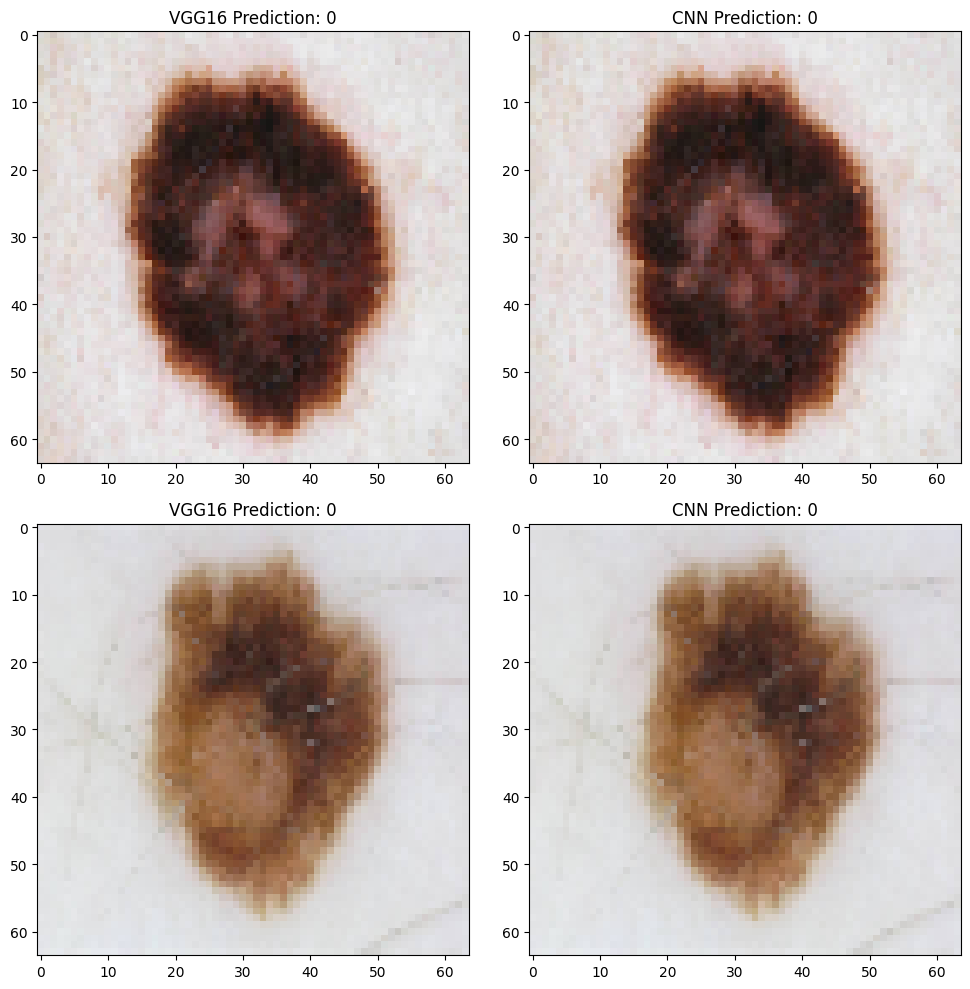

In [8]:
import matplotlib.pyplot as plt

# Get the number of images
n = int(input("Enter the number of images: "))

# List of image paths
img_paths = [input(f"Enter the path of image {i+1}: ") for i in range(n)]

fig, axs = plt.subplots(n, 2, figsize=(10, n * 5))

for i, img_path in enumerate(img_paths):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make predictions with both models
    vgg16_preds = vgg16_model.predict(x)
    cnn_preds = cnn_model.predict(x)

    # Convert predictions to class labels
    vgg16_preds = np.argmax(vgg16_preds, axis=1)
    cnn_preds = np.argmax(cnn_preds, axis=1)

    # Plot the image and predictions
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f'VGG16 Prediction: {vgg16_preds[0]}')
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(f'CNN Prediction: {cnn_preds[0]}')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 26ms/step


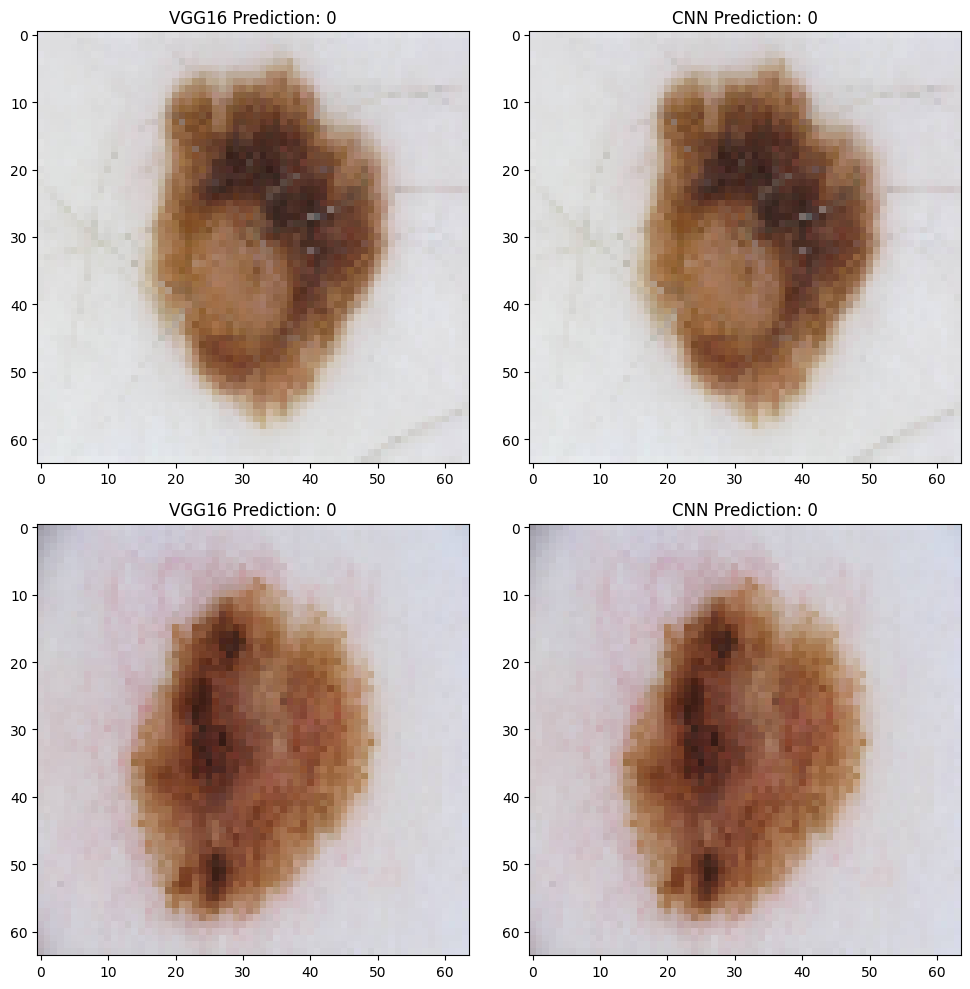

In [10]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the trained models
vgg16_model = load_model('F://AI ML//Vgn_Weight_tf//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
cnn_model = load_model('F://AI ML//benign-vs-malignant_64_rmsprop_0.373.h5')

# Get the number of images
n = int(input("Enter the number of images: "))

# List of image paths
img_paths = [input(f"Enter the path of image {i+1}: ") for i in range(n)]

fig, axs = plt.subplots(n, 2, figsize=(10, n * 5))

for i, img_path in enumerate(img_paths):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make predictions with both models
    vgg16_preds = vgg16_model.predict(x)
    cnn_preds = cnn_model.predict(x)

    # Convert predictions to class labels
    vgg16_preds = np.argmax(vgg16_preds, axis=1)
    cnn_preds = np.argmax(cnn_preds, axis=1)

    # Plot the image and predictions
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f'VGG16 Prediction: {vgg16_preds[0]}')
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(f'CNN Prediction: {cnn_preds[0]}')

plt.tight_layout()
plt.show()